## Motivation

- Implement the algorithm SimpleTagBased, NormTagBased and TagBased-TFIDF with dataset [delicious](./delicious-2k/user_taggedbookmarks-timestamps.dat)
- Clean dataset [Titanic](./titanic/train.csv)

## Model of TagBased

- Score of **SimpleTagBased**
$$score(u,i)=\sum_t user\_tags[u,t] \times tag\_items[t,i]$$
where $user\_tags[u,t]$ is denoted times of user $u$ uses tag $t$, and $tag\_items[t, i]$ is denoted times of item $i$ tagged by tag $t$.
- Score of **NormTagBased**
$$score(u,i)=\sum_t\frac{user\_tags[u,t]}{user\_tags[u]} \times \frac{tag\_items[t,i]}{tag\_items[t]}$$
- Score of **TagBased-TFIDF**
$$score(u,i)=\sum_t \frac{user\_tags[u,t]}{log(1+tag\_users[t])} \times tag\_items[t,i]$$

## Model of Clean Titanic
- 
- 

In [9]:
import numpy as np
import pandas as pd
import random
import operator

## Delicious-Simple/Norm/TFIDF

In [10]:
class TagBased(object):
    def __init__(self, filename, tagbased='simple'):
        self.filename = filename
        self.load_data()
        self.random_split_data(0.2)
        self.init_state()
        self.test_recommend(tagbased)
    
    def load_data(self):
        print('loading data.....')
        filename = self.filename
        self.records = {}
        data = pd.read_csv(filename, delimiter='\t')
        for index, row in data.iterrows():
            # user for some book setting tag
            uid, bid, tid = row['userID'], row['bookmarkID'], row['tagID']
            # graph or tree
            self.records.setdefault(uid, {})
            self.records[uid].setdefault(bid, [])
            self.records[uid][bid].append(tid)
        print('Size of Data Set', data.shape[0])
        print('Number of person who sets tags', len(self.records))
        print('Finish Loading Data')
        
    def random_split_data(self, ratio, seed=2020):
        print('spliting data randomly.....')
        random.seed(seed)
        # build user-book according to tag
        self.train = {}
        self.test = {}
        for user in self.records.keys():
            for book in self.records[user].keys():
                if random.random() < ratio:
                    self.test.setdefault(user, {})
                    self.test[user].setdefault(book, [])
                    for tag in self.records[user][book]:
                        self.test[user][book].append(tag)
                else:
                    self.train.setdefault(user, {})
                    self.train[user].setdefault(book, [])
                    for tag in self.records[user][book]:
                        self.train[user][book].append(tag)
        print('Size of train ', len(self.train), '\nSize of test ', len(self.test))
        
    def init_state(self):
        print('initing the mainly variable.......')
        records = self.train
        self.user_tags = {}
        self.tag_books = {}
        self.user_books = {}
        for user, books in records.items():
            for book, tags in books.items():
                for tag in tags:
                    # The relationship between user and tag
                    self._add_value2mat(self.user_tags, user, tag, 1)
                    # the relationship between tag and item
                    self._add_value2mat(self.tag_books, tag, book, 1)
                    # the relationship between user and item
                    self._add_value2mat(self.user_books, user, book, 1)
        print('user_tags, tag_books, user_books initialize finish.')
        print('size of user_tags is {}, size of tag_books is {}, size of user_books is {}.'.format(len(self.user_tags), len(self.tag_books), len(self.user_books)))
    
    def _add_value2mat(self, dic, key, item, value=1):
        # build the number of key-value
        if key not in dic:
            dic.setdefault(key, {})
            dic[key].setdefault(item, value)
        else:
            if item not in dic[key]:
                dic[key][item] = value
            else:
                dic[key][item] += value
        
    
    def precision_and_recall(self, N, tagbased='simple'):
        print('calcing the precision and recall......')
        hit = 0
        h_recall = 0
        h_precision = 0
        for user, books in self.test.items():
            # if user not in trainset, we can't get some important things
            if user not in self.train:
                continue
            rank = self.recommend(user, N, tagbased)
            for book, rui in rank:
                if book in books:
                    hit += 1
            h_recall += len(books)
            h_precision += N
        return 1. * hit / h_precision, 1. * hit / h_recall
    # get Top N
    def recommend(self, user, N, tagbased='simple'):
        '''tagbased="simple"/"norm"/"tfidf"
        '''
#         print('recommending top-N for user.........')
        recommend_books = {}
        # scored for book, scores for sum (times of user using tag, multipy times of book using the same tag.)
        tagged_books= self.user_books[user]
        len_user_tags = len(self.user_tags[user])
        for tag, wut in self.user_tags[user].items():
            len_tag_books = len(self.tag_books[tag])
            for book, wti in self.tag_books[tag].items():
                if book in tagged_books:
                    continue
                if tagbased == 'norm':
                    wti = 1. * wti / len_tag_books
                    wut = 1. * wut / len_user_tags
                elif tagbased == 'tdidf':
                    wut = 1. * wut / np.log2(1 + len_user_tags)
                    
                if book not in recommend_books:
                    recommend_books[book] = wti * wut
                else:
                    recommend_books[book] += wti * wut  
        return sorted(recommend_books.items(), key=operator.itemgetter(1), reverse=True)[0:N]

    def test_recommend(self, tagbased='simple'):
        print('result for result evaluation:')
        print("%3s %10s %10s" % ('N',"precision",'recall'))
        for n in [5,10,20,40,60,80,100]:
            precision, recall = self.precision_and_recall(n, tagbased)
            print(precision, recall)
            print("%3d %10.3f%% %10.3f%%" % (n, precision * 100, recall * 100))

In [11]:
stb = TagBased('./delicious-2k/user_taggedbookmarks-timestamps.dat', 'simple')

loading data.....
Size of Data Set 437593
Number of person who sets tags 1867
Finish Loading Data
spliting data randomly.....
Size of train  1864 
Size of test  1775
initing the mainly variable.......
user_tags, tag_books, user_books initialize finish.
size of user_tags is 1864, size of tag_books is 36798, size of user_books is 1864.
result for result evaluation:
  N  precision     recall
calcing the precision and recall......
0.009932279909706547 0.00421072778601847
  5      0.993%      0.421%
calcing the precision and recall......
0.007392776523702032 0.006268242499641131
 10      0.739%      0.627%
calcing the precision and recall......
0.005135440180586907 0.008708550648356381
 20      0.514%      0.871%
calcing the precision and recall......
0.003781038374717833 0.012823580075601703
 40      0.378%      1.282%
calcing the precision and recall......
0.003094431903686983 0.015742380018182688
 60      0.309%      1.574%
calcing the precision and recall......
0.002765237020316027 0.01

In [12]:
stb = TagBased('./delicious-2k/user_taggedbookmarks-timestamps.dat', 'norm')

loading data.....
Size of Data Set 437593
Number of person who sets tags 1867
Finish Loading Data
spliting data randomly.....
Size of train  1864 
Size of test  1775
initing the mainly variable.......
user_tags, tag_books, user_books initialize finish.
size of user_tags is 1864, size of tag_books is 36798, size of user_books is 1864.
result for result evaluation:
  N  precision     recall
calcing the precision and recall......
0.004063205417607223 0.0017225704579166467
  5      0.406%      0.172%
calcing the precision and recall......
0.003216704288939052 0.0027274032250346907
 10      0.322%      0.273%
calcing the precision and recall......
0.0024830699774266367 0.00421072778601847
 20      0.248%      0.421%
calcing the precision and recall......
0.0020033860045146727 0.0067945834728934396
 40      0.200%      0.679%
calcing the precision and recall......
0.0016835966892400302 0.00856500311019666
 60      0.168%      0.857%
calcing the precision and recall......
0.001530756207674943

In [13]:
stb = TagBased('./delicious-2k/user_taggedbookmarks-timestamps.dat', 'tfidf')

loading data.....
Size of Data Set 437593
Number of person who sets tags 1867
Finish Loading Data
spliting data randomly.....
Size of train  1864 
Size of test  1775
initing the mainly variable.......
user_tags, tag_books, user_books initialize finish.
size of user_tags is 1864, size of tag_books is 36798, size of user_books is 1864.
result for result evaluation:
  N  precision     recall
calcing the precision and recall......
0.009932279909706547 0.00421072778601847
  5      0.993%      0.421%
calcing the precision and recall......
0.007392776523702032 0.006268242499641131
 10      0.739%      0.627%
calcing the precision and recall......
0.005135440180586907 0.008708550648356381
 20      0.514%      0.871%
calcing the precision and recall......
0.003781038374717833 0.012823580075601703
 40      0.378%      1.282%
calcing the precision and recall......
0.003094431903686983 0.015742380018182688
 60      0.309%      1.574%
calcing the precision and recall......
0.002765237020316027 0.01

|       |Simple        |TagBased    |Norm          |TagBased  |TFIDF|TagBased|
| :----:|     :----:   |   :----:   |    :----:    |:----:    |   :----:    |:----:    |
| N     | Precision    | Recall     |Precision     | Recall   |Precision    | Recall   |
| 5     | 0.993%        | 0.421%     |0.406% |0.172% |0.993%       | 0.421% |
| 10    | 0.739%        |  0.627%     |0.322%|0.273%   |0.739%       | 0.627% |
|20|0.514% |0.871%|0.248%|0.421%|0.514% |0.871%|
|40|0.378%|1.282%|0.200%|0.679%|0.378%|1.282%|
|60|0.309%|1.574%|0.168% | 0.857%|0.309%|1.574%|
|80|0.277%|1.876%|0.153%|1.038%|0.277% |1.876%|
|100|0.249%|2.115%|0.133%  | 1.124%|0.249%|2.115%|

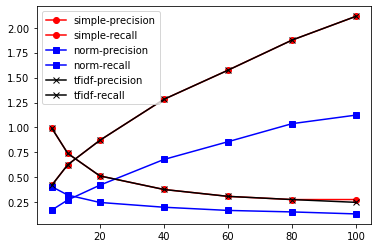

In [29]:
# why not return a variable, SB
simple_tb_pre = [0.993, 0.739, 0.514, 0.378, 0.309, 0.277, 0.277]
simple_tb_re = [0.421, 0.627, 0.871, 1.282,1.574,1.876, 2.115]
norm_tb_pre = [0.406, 0.322, 0.248, 0.200, 0.168, 0.153, 0.133]
norm_tb_re = [0.172,0.273,0.421,0.679,0.857,1.038,1.124]
tfidf_tb_pre = [0.993,0.739,0.514,0.378,0.309, 0.277, 0.249]
tfidf_tb_re = [0.421,0.627, 0.871, 1.282, 1.574, 1.876, 2.115]
x = [5, 10, 20, 40, 60, 80, 100]
import matplotlib.pyplot as plt
plt.plot(x, simple_tb_pre, 'ro-', label='simple-precision')
plt.plot(x, simple_tb_re, 'ro-',label='simple-recall')
plt.plot(x, norm_tb_pre, 'bs-', label='norm-precision')
plt.plot(x, norm_tb_re, 'bs-',label='norm-recall')
plt.plot(x, tfidf_tb_pre, 'kx-', label='tfidf-precision')
plt.plot(x, tfidf_tb_re, 'kx-',label='tfidf-recall')
plt.legend()

## Clean Titanic

### Import Libraries

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import os

In [2]:
train = pd.read_csv('../L2/titanic/train.csv')
test = pd.read_csv('../L2/titanic/test.csv')

In [4]:
from pandas_profiling import ProfileReport

### Trainset

In [5]:
train_profile_report = ProfileReport(train, 'Train Set Profiling Report', html={'style':{'full_width':True}})

In [7]:
train_profile_report.to_notebook_iframe()

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [10]:
train.shape

(891, 12)

In [12]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [20]:
train.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
207,208,1,3,"Albimona, Mr. Nassef Cassem",male,26.0,0,0,2699,18.7875,NaN,C
266,267,0,3,"Panula, Mr. Ernesti Arvid",male,16.0,4,1,3101295,39.6875,NaN,S
252,253,0,1,"Stead, Mr. William Thomas",male,62.0,0,0,113514,26.5500,C87,S
411,412,0,3,"Hart, Mr. Henry",male,NaN,0,0,394140,6.8583,NaN,Q
540,541,1,1,"Crosby, Miss. Harriet R",female,36.0,0,2,WE/P 5735,71.0000,B22,S


### Testset

In [14]:
test_profile_report = ProfileReport(test, 'Test Set Profiling Report', html={'style':{'full_width':True}})

In [15]:
test_profile_report.to_notebook_iframe()

In [16]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [17]:
test.shape

(418, 11)

In [21]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [22]:
test.sample()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
210,1102,3,"Andersen, Mr. Albert Karvin",male,32.0,0,0,C 4001,22.525,NaN,S


### Overview And Cleaning The Data
- missing values 
- categorical features
- alphanumerical or/and text features

#### Missing Values

In [24]:
def missing_precentage(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = round(total/len(df)*100, 2)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percentage'])

In [25]:
missing_precentage(train)

,Total,Percentage
Cabin,687,77.10
Age,177,19.87
Embarked,2,0.22
Fare,0,0.00
Ticket,0,0.00
Parch,0,0.00
SibSp,0,0.00
Sex,0,0.00
Name,0,0.00
Pclass,0,0.00


In [26]:
missing_precentage(test)

,Total,Percentage
Cabin,327,78.23
Age,86,20.57
Fare,1,0.24
Embarked,0,0.00
Ticket,0,0.00
Parch,0,0.00
SibSp,0,0.00
Sex,0,0.00
Name,0,0.00
Pclass,0,0.00


##### Embarked Features
- fill NaN with the relationship between ***Fare*** and ***Pclass*** under ***Embarked***

In [27]:
def value_counts_percentage(df, features):
    total = round(df.loc[:, features].value_counts(dropna=False))
    percentage = pd.DataFrame(round(df.loc[:, features].value_counts(dropna=False, normalize=True) * 100, 2))
    total.columns = ['Total']
    percentage.columns = ['Percentage']
    return pd.concat([total, percentage], axis=1)

In [28]:
value_counts_percentage(train, 'Embarked')

,Embarked,Percentage
S,644,72.28
C,168,18.86
Q,77,8.64
NaN,2,0.22


In [29]:
train[train.Embarked.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


**notice**
- Both above passengers paid a fare of $\$80$, ara of Pclass $1$ and female Sex. Let's see how the ***Fare*** is distributed among all ***Pclass*** and ***Embarked*** feature values.

Text(0.5, 1.0, 'Test Set')

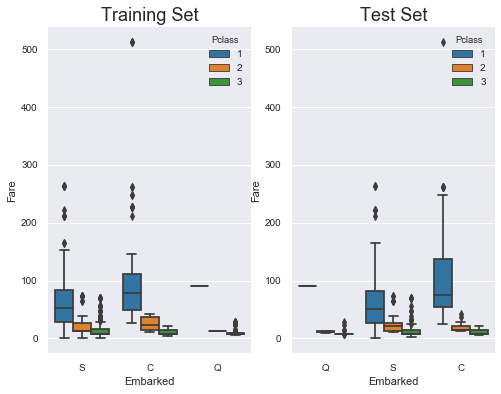

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(8,6),ncols=2)
ax1 = sns.boxplot(x="Embarked", y="Fare", hue="Pclass", data=train, ax = ax[0]);
ax2 = sns.boxplot(x="Embarked", y="Fare", hue="Pclass", data=test, ax = ax[1]);
ax1.set_title("Training Set", fontsize = 18)
ax2.set_title('Test Set',  fontsize = 18)

In [32]:
# replacing the null values in the Embarked column with the mode
train.Embarked.fillna('C', inplace=True)

##### Cabin Feature

In [33]:
value_counts_percentage(train, 'Cabin')

,Cabin,Percentage
NaN,687,77.10
C23 C25 C27,4,0.45
B96 B98,4,0.45
G6,4,0.45
D,3,0.34
...,...,...
C110,1,0.11
B80,1,0.11
E46,1,0.11
B30,1,0.11


In [34]:
value_counts_percentage(test, 'Cabin')

,Cabin,Percentage
NaN,327,78.23
B57 B59 B63 B66,3,0.72
F4,2,0.48
E34,2,0.48
C31,2,0.48
...,...,...
D40,1,0.24
C54,1,0.24
B26,1,0.24
E52,1,0.24


***notice***
- Approximately 77% of Cabin feature is missing in the training data and 78% missing on the test data.
    - get rid of the whole feature
    - assign all the null values as 'N'

In [36]:
surviers = train.Survived
train.drop(['Survived'], axis=1, inplace=True)
all_data = pd.concat([train, test], ignore_index=False)
all_data.Cabin.fillna('N', inplace=True)

***notice***
- It seems like there is a significance with the letters rather than the numbers.

In [40]:
all_data.Cabin = [i[0] for i in all_data.Cabin]

In [41]:
value_counts_percentage(all_data, 'Cabin')

,Cabin,Percentage
N,1014,77.46
C,94,7.18
B,65,4.97
D,46,3.51
E,41,3.13
A,22,1.68
F,21,1.60
G,5,0.38
T,1,0.08


In [42]:
all_data.groupby('Cabin')['Fare'].mean().sort_values()

Cabin
G     14.205000
F     18.079367
N     19.132707
T     35.500000
A     41.244314
D     53.007339
E     54.564634
C    107.926598
B    122.383078
Name: Fare, dtype: float64

In [43]:
with_N = all_data[all_data.Cabin == 'N']
without_N = all_data[all_data.Cabin != 'N']

***notice***
- with_N data reset the Cabin

In [44]:
def cabin_estimator(val):
    letter = 0
    if val < 16:
        letter = 'G'
    elif val >= 16 and val < 27:
        letter = 'F'
    elif val >= 27 and val < 38:
        letter = 'T'
    elif val >= 38 and val < 47:
        letter = 'A'
    elif val >= 47 and val < 53:
        letter = 'E'
    elif val >= 53 and val < 54:
        letter = 'D'
    elif val >= 54 and val < 116:
        letter = 'C'
    else:
        letter = 'B'
    return letter

In [46]:
with_N['Cabin'] = with_N.Fare.apply(lambda x : cabin_estimator(x))
all_data = pd.concat([with_N, without_N], axis=0)
all_data.sort_values(by='PassengerId', inplace=True)
train = all_data[:891]
test = all_data[891:]
train['Survived'] = surviers

In [47]:
train.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,G,S,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,1
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,G,S,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S,1
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,G,S,0


In [48]:
test.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,G,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,G,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,G,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,G,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,G,S


##### Fare

In [50]:
test[test.Fare.isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,B,S


***Single sample fill***
- use the mean values where Pclass=3 and Sex=male and Embarked='S'

In [51]:
missing_value = test[(test.Pclass == 3) & (test.Embarked == 'S') & (test.Sex == 'male')].Fare.mean()
test.Fare.fillna(missing_value, inplace=True)

##### Age

***notice***
- About $20\%$ data in the Age columns is missing in both train and test set. Think about using the Random Forest Regressor to impute missing value.

In [52]:
pd.DataFrame(abs(train.corr()['Survived']).sort_values(ascending=False))

,Survived
Survived,1.000000
Pclass,0.338481
Fare,0.257307
Parch,0.081629
Age,0.077221
SibSp,0.035322
PassengerId,0.005007


Text(0.5, 1.03, 'Correlations Among Features')

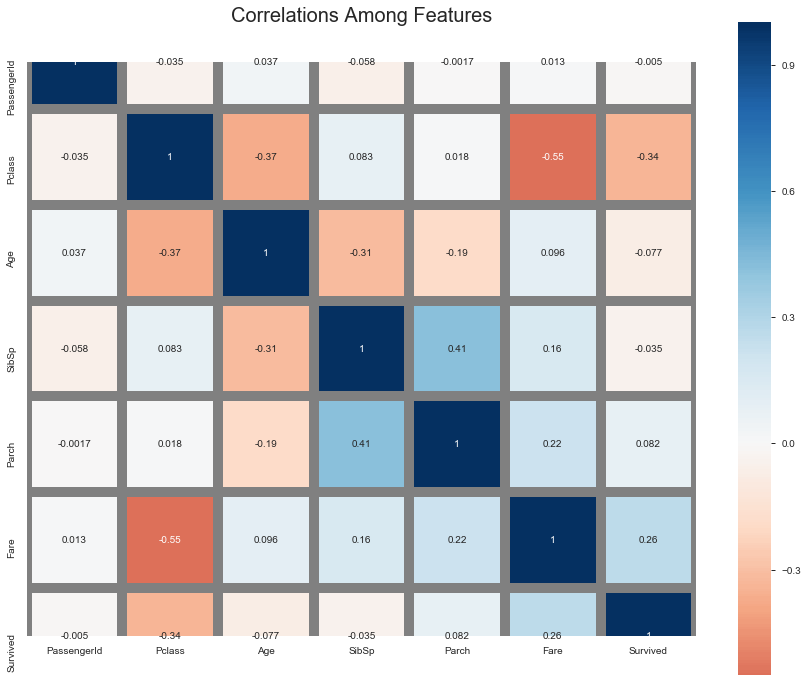

In [53]:
import numpy as np
mask = np.zeros_like(train.corr(), dtype=np.bool)

plt.subplots(figsize=(15,12))
sns.heatmap(train.corr(),
           annot=True,
           mask=mask,
           cmap='RdBu',
           linewidths=9,
           linecolor='gray',
           fmt='.2g',
           center=0,
           square=True)
plt.title('Correlations Among Features', y=1.03, fontsize=20,pad=40)

### Feature Engine
- Need to deal with features which are strongly relationship to age, and make them numerical. 

In [55]:
from sklearn.ensemble import RandomForestRegressor

def completing_age(df):
    age_df = df.loc[:,'Age':'Cabin']
    
    temp_train = age_df.loc[age_df.Age.notnull()]
    temp_test = age_df.loc[age_df.Age.isnull()]
    
    y = temp_train.Age.values
    x = temp_train.loc[:, 'Sex':].values
    
    rfr = RandomForestRegressor(n_estimators=1500, n_jobs=-1)
    rfr.fit(x, y)
    
    predicted_age = rfr.predict(temp_test.loc[:,'Sex'])
    
    df.loc[df.Age.isnull(), 'Age'] = predict_age
    
    return df

In [54]:
train.loc[:, 'Age':]

,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,22.0,1,0,A/5 21171,7.2500,G,S,0
1,38.0,1,0,PC 17599,71.2833,C,C,1
2,26.0,0,0,STON/O2. 3101282,7.9250,G,S,1
3,35.0,1,0,113803,53.1000,C,S,1
4,35.0,0,0,373450,8.0500,G,S,0
...,...,...,...,...,...,...,...,...
886,27.0,0,0,211536,13.0000,G,S,0
887,19.0,0,0,112053,30.0000,B,S,1
888,NaN,1,2,W./C. 6607,23.4500,F,S,0
889,26.0,0,0,111369,30.0000,C,C,1


***Warnings***
- The clean work haven't finish, but the idea should be good. come on!!!!

[1.A Statistical Analysis & ML workflow of Titanic](https://www.kaggle.com/masumrumi/a-statistical-analysis-ml-workflow-of-titanic)